<b>Segmentation of TravelTide Data Using the K-Means Algorithm - Dokleat Halilaj</b>

The primary goal of this project is to delve deeper into customer behavior and preferences within the TravelTide database. By employing clustering analysis, this project seeks to pinpoint distinct segments of customers, characterized by specific spending patterns, booking habits, and travel preferences. The objective is to enable the assignment of customers to one of five tailored perks based on their behaviors.

The five perks are as follows:

- <b>One Night Free Hotel With Flight</b>
- <b>Free Hotel Meal</b>
- <b>Free Cancellation</b>
- <b>Free Checked Bag</b>
- <b>Exclusive Discounts</b>

The insights derived from this analysis will facilitate the development of targeted marketing strategies and perk allocations, ensuring they meet the specific needs and desires of each customer cluster.

The data utilised in this project has been sourced directly from the TravelTide database. The directive, received from the head of marketing, was to encompass sessions commencing after <b>04/01/2023,</b> extending up to the most recent available date, which is <b>29/07/2023</b>. It was stipulated that only users with more than <b>7 sessions</b> during this time frame should be considered.

I collected the relevant data by running an SQL query and saving the results as a CSV file to use in this Jupyter notebook.

In the notebook, I start by cleaning and preparing the data. Then, I use K-Means clustering to group users based on their behavior. After that, I explore the clusters to find useful insights. Finally, I summarise my findings, conclusions, and recommendations in this report.

<b>Importing and Viewing the Data</b>

The initial step involves importing and examining the data to glean insights into its structure and content. I also use this space to import the assorted modules and libraries that I will need in subsequent stages of analysis. This process of data inspection gives me a preliminary understanding of its appearance, identifies numerical columns, and allows me to consider any potential adjustments required in terms of data presentation.

In [31]:
%matplotlib inline
import pandas as pd
from tabulate import tabulate
from IPython.display import HTML
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from math import radians, atan2, sqrt, sin, cos
from datetime import timedelta
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances


#Import data
df = pd.read_csv('TravelTide_for_Python.csv')


# Create a formatted table as HTML
table_html = tabulate(df.head(), headers='keys', tablefmt='html')

# Display the table
HTML(table_html)

,user_id,birthdate,gender,married,has_children,home_country,home_city,home_airport,sign_up_date,num_sessions,total_page_clicks,total_flight_discount,total_hotel_discount,total_flights_booked,total_hotels_booked,total_cancellations,total_checked_bags,destination_airport_lat,destination_airport_lon,home_airport_lat,home_airport_lon,seats,rooms,departure_time,return_time,session_start,session_end,trip_id
0,94883,1972-03-16,F,True,False,usa,kansas city,MCI,2022-02-07,8,73,0,1,2,2,0,1,43.862,-79.37,39.297,-94.714,3,3,2023-04-16 10:00:00,2023-04-17 10:00:00,2023-05-28 17:28:00,2023-05-28 17:28:23,94883-bcc118ad37024c4ab14c62d46daf2ac0
1,153982,1978-08-15,F,False,True,canada,toronto,YKZ,2022-04-19,8,150,0,1,3,3,0,1,51.114,-73.779,43.862,-79.37,3,3,2023-07-31 11:00:00,2023-08-03 11:00:00,2023-07-20 20:37:00,2023-07-20 20:45:14,153982-f2187763b9a242f3b923b32ff0e3c7ab
2,167852,2006-02-16,F,False,False,usa,tampa,MCF,2022-05-03,8,63,1,2,0,0,0,nan,nan,nan,27.849,-82.521,nan,nan,nan,nan,2023-04-25 17:14:00,2023-04-25 17:14:14,nan
3,181157,1970-08-10,F,True,False,usa,houston,HOU,2022-05-15,8,153,2,1,3,3,0,3,35.393,-97.601,29.645,-95.279,6,6,2023-04-03 11:00:00,2023-04-07 11:00:00,2023-07-07 10:41:00,2023-07-07 10:42:16,181157-9d86219fb6574ef291b265f78e291c04
4,252835,1986-01-20,F,False,True,usa,chicago,ORD,2022-07-18,8,117,1,1,5,4,0,3,53.667,-73.779,41.979,-87.904,5,4,2023-07-19 10:00:00,2023-07-23 10:00:00,2023-07-10 06:24:00,2023-07-10 06:27:15,252835-db62add9d6364162adc85cc234a12552


Taking a look at the table, I can see that I have some missing values. It's also worth mentioning that a portion of the data is in boolean format, which I've chosen to convert into integers. This change gives me more flexibility for future use.

In [2]:
# Convert boolean columns to numerical
df['married'] = df['married'].astype(int)
df['has_children'] = df['has_children'].astype(int)

<b>Dropping the Unnecessary Column</b>

Before addressing the missing values, I've observed the presence of the 'trip_id' column in my dataset. Since this column doesn't serve a purpose in my analysis, I've decided to remove it.

In [3]:
# Drop the "trip_id" column
df = df.drop(columns=['trip_id'])

<b>Checking for Missing Values</b>

I already know that my dataset contains some missing values, so now I want to identify all columns that contain missing values within the dataset. This process will be revisited at later stages to ensure the integrity of the analysis.

In [4]:
#Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

user_id                      0
birthdate                    0
gender                       0
married                      0
has_children                 0
home_country                 0
home_city                    0
home_airport                 0
sign_up_date                 0
num_sessions                 0
total_page_clicks            0
total_flight_discount        0
total_hotel_discount         0
total_flights_booked         0
total_hotels_booked          0
total_cancellations          0
total_checked_bags         818
destination_airport_lat    818
destination_airport_lon    818
home_airport_lat             0
home_airport_lon             0
seats                      818
rooms                      596
departure_time             818
return_time                876
session_start                0
session_end                  0
dtype: int64


<b>Checking for Infinite Values</b>

The output highlights columns with missing values, which, considering their context, appear related to customers who visited TravelTide but did not make bookings. I've chosen to address these missing values to prepare the data for analysis. Additionally, I'm checking for any infinite values within the dataset before proceeding.

In [5]:
# List of columns to check
columns_to_check = ['num_sessions', 'total_page_clicks', 'total_flight_discount', 'total_hotel_discount',
                    'total_flights_booked', 'total_hotels_booked', 'total_cancellations', 'total_checked_bags',
                    'destination_airport_lat', 'destination_airport_lon', 'seats', 'rooms', 'departure_time',
                    'return_time', 'session_start', 'session_end']

# Filter columns to check only numeric columns
numeric_columns_to_check = [col for col in columns_to_check if df[col].dtype in (np.float64, np.int64)]

# Check for infinite values
infinite_value_counts = df[numeric_columns_to_check].apply(np.isinf).sum()

print("Infinite value counts:")
print(infinite_value_counts)

Infinite value counts:
num_sessions               0
total_page_clicks          0
total_flight_discount      0
total_hotel_discount       0
total_flights_booked       0
total_hotels_booked        0
total_cancellations        0
total_checked_bags         0
destination_airport_lat    0
destination_airport_lon    0
seats                      0
rooms                      0
dtype: int64


The output tells me that we currently have no infinite values, but I will be checking this throughout the process, particularly when using calculations to create new features.

<b>Handling Missing Values</b>

To ensure data integrity, I'm handling missing values by removing the rows with missing values in the specified columns. This decision is based on the observation that these missing values relate to users who didn't make any bookings. This process helps maintain data consistency and ensures that our analysis accurately reflects customer behavior, particularly the absence of engagement in trip-related activities by certain users.

In [6]:
# List of columns with missing values
columns_to_check = ['departure_time', 'return_time', 'total_checked_bags', 'destination_airport_lat', 'destination_airport_lon', 'seats', 'rooms']

# Remove rows with missing values in the specified columns
df = df.dropna(subset=columns_to_check)

# Display the DataFrame after removing rows
df.head()


,user_id,birthdate,gender,married,has_children,home_country,home_city,home_airport,sign_up_date,num_sessions,...,destination_airport_lat,destination_airport_lon,home_airport_lat,home_airport_lon,seats,rooms,departure_time,return_time,session_start,session_end
0,94883,1972-03-16,F,1,0,usa,kansas city,MCI,2022-02-07,8,...,43.862,-79.370,39.297,-94.714,3.0,3.0,2023-04-16 10:00:00,2023-04-17 10:00:00,2023-05-28 17:28:00,2023-05-28 17:28:23
1,153982,1978-08-15,F,0,1,canada,toronto,YKZ,2022-04-19,8,...,51.114,-73.779,43.862,-79.370,3.0,3.0,2023-07-31 11:00:00,2023-08-03 11:00:00,2023-07-20 20:37:00,2023-07-20 20:45:14
3,181157,1970-08-10,F,1,0,usa,houston,HOU,2022-05-15,8,...,35.393,-97.601,29.645,-95.279,6.0,6.0,2023-04-03 11:00:00,2023-04-07 11:00:00,2023-07-07 10:41:00,2023-07-07 10:42:16
4,252835,1986-01-20,F,0,1,usa,chicago,ORD,2022-07-18,8,...,53.667,-73.779,41.979,-87.904,5.0,4.0,2023-07-19 10:00:00,2023-07-23 10:00:00,2023-07-10 06:24:00,2023-07-10 06:27:15
5,283325,1973-05-15,F,1,0,usa,dallas,DAL,2022-08-12,8,...,46.788,-71.398,32.847,-96.852,1.0,3.0,2023-03-05 14:00:00,2023-03-11 14:00:00,2023-06-22 21:04:00,2023-06-22 21:05:53


The table demonstrates that the changes I made were successful.

<b>Overview of the Data</b>

I'm now conducting a summary analysis of specific numerical columns in the DataFrame. These columns, stored in a variable named <b>stats_columns,</b> are chosen for their relevance to user behavior and booking details. Using the <b>describe()</b> function, I'll obtain essential statistical metrics, providing a quick and informative overview of the selected columns' characteristics. This summary streamlines data exploration and understanding.

In [8]:
# Define the numerical columns to include in the summary
numerical_columns = ['num_sessions', 'total_page_clicks', 'total_flight_discount', 'total_hotel_discount',
                     'total_flights_booked', 'total_hotels_booked', 'total_cancellations', 'total_checked_bags',
                     'seats', 'rooms']

# Generate the statistical summary for numerical columns
summary = df[numerical_columns].describe().T

# Display the summary
display(summary)


,count,mean,std,min,25%,50%,75%,max
num_sessions,4986.0,8.207982,0.464016,8.0,8.0,8.0,8.0,11.0
total_page_clicks,4986.0,151.356799,72.661516,49.0,109.0,133.0,165.0,873.0
total_flight_discount,4986.0,1.499198,1.112751,0.0,1.0,1.0,2.0,6.0
total_hotel_discount,4986.0,1.141596,1.000906,0.0,0.0,1.0,2.0,6.0
total_flights_booked,4986.0,2.815082,1.334032,1.0,2.0,3.0,4.0,9.0
total_hotels_booked,4986.0,2.870437,1.310577,1.0,2.0,3.0,4.0,9.0
total_cancellations,4986.0,0.108905,0.320439,0.0,0.0,0.0,0.0,2.0
total_checked_bags,4986.0,1.655235,1.429896,0.0,1.0,1.0,2.0,17.0
seats,4986.0,3.398516,1.927011,1.0,2.0,3.0,4.0,17.0
rooms,4986.0,3.381869,1.790363,1.0,2.0,3.0,4.0,14.0


This summary offers insights into the central tendencies, spreads, and distributions of numerical features in the dataset. Notably, two columns, </b>num_sessions</b> and <b>total_cancellations,</b> exhibit limited variability. While <b>num_sessions</b> isn't a significant concern for user engagement analysis, <b>total_cancellations</b> is vital when considering the <b>Free Cancellation</b> perk. I can also see here that removing the rows with missing data was successful, because I know that my dataset originally contained 5998 rows, and the count for each of these columns has been updated to 4986.

<u><b>num_sessions:</b></u>

- 4986 data points
- Average: Approximately 8.20 sessions per user
- Low variability (Standard Deviation ≈ 0.46)
- Most users (25th to 75th percentile) have 8 sessions or fewer
- Median: 8 sessions
- Range: 8 to 11 sessions

<u><b>total_cancellations:</b></u>

- 4986 data points
- Average: Approximately 0.11 cancellations per user
- Low variability (Standard Deviation ≈ 0.32)
- The majority of users report zero cancellations
- Median: 0 cancellations
- Range: 0 to 2 cancellations"

<b>Visualising Outliers and Shape</b>

As the next step in the analysis, I explore the statistical characteristics of the data by visualising potential outliers and assessing the overall distribution. This helps me to identify anomalies or underlying patterns within the numerical features. The following code segment displays histograms and box plots for specific numerical columns, offering a comprehensive view of their data distributions and highlighting any notable trends or data points.

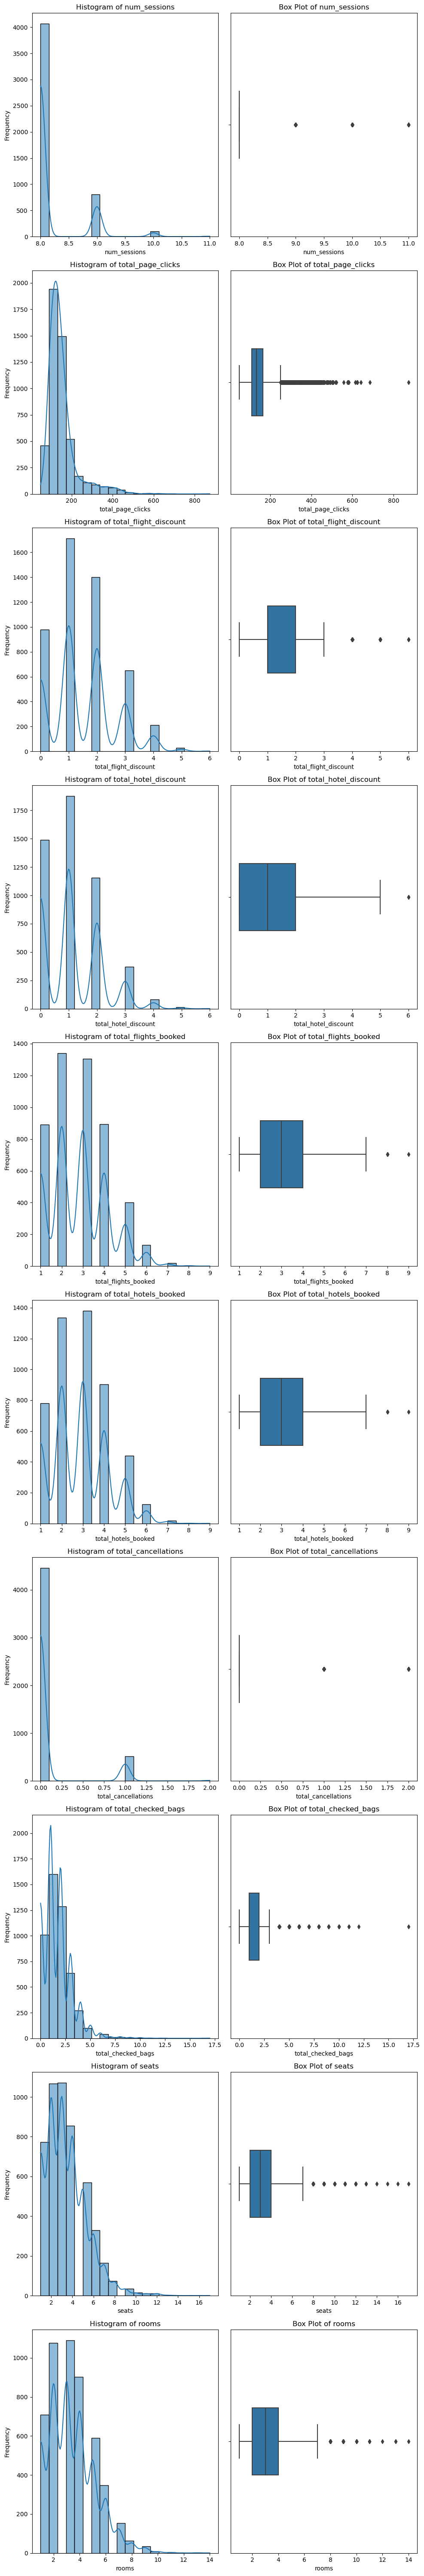

In [9]:
# Select numerical columns for analysis
numerical_columns = ['num_sessions', 'total_page_clicks', 'total_flight_discount', 'total_hotel_discount',
                     'total_flights_booked', 'total_hotels_booked', 'total_cancellations', 'total_checked_bags',
                     'seats', 'rooms']

# Calculate the number of rows for the subplots
num_plots = len(numerical_columns)

# Create subplots with histograms and box plots
fig, axes = plt.subplots(num_plots, 2, figsize=(10, 6 * num_plots))
fig.subplots_adjust(hspace=0.5)

for i, column in enumerate(numerical_columns):
    # Histogram
    sns.histplot(data=df, x=column, ax=axes[i, 0], bins=20, kde=True)
    axes[i, 0].set_title(f'Histogram of {column}')
    axes[i, 0].set_xlabel(column)
    axes[i, 0].set_ylabel('Frequency')
    
    # Box Plot
    sns.boxplot(data=df, x=column, ax=axes[i, 1], width=0.3)
    axes[i, 1].set_title(f'Box Plot of {column}')
    axes[i, 1].set_xlabel(column)
    axes[i, 1].set_ylabel('')

plt.tight_layout()
plt.show()

<b>Handling Outliers</b>

The analysis revealed a few columns with outliers, but only two raised slight concerns. As expected, the <b>num_sessions</b> and <b>total_cancellations</b> columns exhibit limited variability due to the specific criteria for selecting users with over 7 sessions. While some columns appear right-skewed, indicating positive outliers, I opted not to remove outliers in <b>num_sessions</b> and <b>total_cancellations</b> to preserve all relevant data points because of their limited variability.

Using the Interquartile Range (IQR) method, I calculated lower and upper bounds for outlier detection based on quartiles. These bounds were applied to cap outliers in all columns, except <b>num_sessions</b> and <b>total_cancellations.</b> This approach aims to balance moderating extreme values without entirely removing or capping them.

The goal in handling outliers in this instance is to strike a balance that respects the complexity of user behavior, preserving important aspects while mitigating the impact of extreme values on the analysis.

In [10]:
# Calculate summary statistics including quartiles
summary = df[numerical_columns].describe(percentiles=[0.25, 0.75])

# Extract the IQR values from the summary DataFrame
Q1 = summary.loc['25%']
Q3 = summary.loc['75%']
IQR = Q3 - Q1

# Calculate lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 2.5 * IQR  

# Handle outliers for all columns except 'num_sessions' and 'total_cancellations'
for column in numerical_columns:
    if column not in ['num_sessions', 'total_cancellations']:
        df[column] = np.where(df[column] < lower_bound[column], lower_bound[column], df[column])
        df[column] = np.where(df[column] > upper_bound[column], upper_bound[column], df[column])


<b>Rewriting the Haversine Function</b>

The initial Haversine function used a simplified version that treated the Earth as a perfect sphere, suitable for short distances but less accurate for longer ones. I improved the function by implementing the Vincenty formula, which considers the Earth's ellipsoidal shape, making it more accurate, especially for longer distances. This enhancement is designed to assist when creating new features later in the analysis.

In [11]:
def haversine_distance(lat1, lon1, lat2, lon2):
    a = 6378137.0  # Earth's equatorial radius in meters
    f = 1 / 298.257223563  # Earth's flattening
    b = (1 - f) * a  # Earth's polar radius in meters
    
    # Convert latitude and longitude from degrees to radians
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    # Calculate auxiliary values
    U1 = atan2((1 - f) * sin(lat1), cos(lat1))
    U2 = atan2((1 - f) * sin(lat2), cos(lat2))
    
    # Calculate the initial longitude difference
    L = lon2 - lon1
    lambda_old = L

    # Initialize iteration limit and perform iterative calculations    
    iter_limit = 100
    for _ in range(iter_limit): 
        
        # Calculate various trigonometric values for the haversine formula

        # Calculate sin(sigma) using trigonometric expressions
        sin_sigma = sqrt((cos(U2) * sin(lambda_old)) ** 2 + (cos(U1) * sin(U2) - sin(U1) * cos(U2) * cos(lambda_old)) ** 2)

        # Calculate cos(sigma) using trigonometric expressions
        cos_sigma = sin(U1) * sin(U2) + cos(U1) * cos(U2) * cos(lambda_old)

        # Calculate sigma (central angle) using arctan2 of sin(sigma) and cos(sigma)
        sigma = atan2(sin_sigma, cos_sigma)

        # Calculate sin(alpha) using trigonometric expressions
        sin_alpha = cos(U1) * cos(U2) * sin(lambda_old) / sin_sigma

        # Calculate cos^2(alpha) as 1 - sin(alpha)^2
        cos2_alpha = 1 - sin_alpha ** 2

        # Calculate cos(2*sigma_m) using trigonometric expressions
        cos_2sigma_m = cos_sigma - 2 * sin(U1) * sin(U2) / cos2_alpha

        # Calculate C factor for the final haversine distance calculation
        C = f / 16 * cos2_alpha * (4 + f * (4 - 3 * cos2_alpha))

        # Calculate lambda_new (longitude difference) based on iterative formula
        lambda_new = L + (1 - C) * f * sin_alpha * (
                sigma + C * sin_sigma * (cos_2sigma_m + C * cos_sigma * (-1 + 2 * cos_2sigma_m ** 2)))

        # Check for convergence        
        if abs(lambda_new - lambda_old) < 1e-12:
            break

        lambda_old = lambda_new
        
    # Calculate additional parameters and the final haversine distance
    u2 = cos2_alpha * ((a ** 2 - b ** 2) / (b ** 2))
    A = 1 + u2 / 16384 * (4096 + u2 * (-768 + u2 * (320 - 175 * u2)))
    B = u2 / 1024 * (256 + u2 * (-128 + u2 * (74 - 47 * u2)))
    delta_sigma = B * sin_sigma * (
            cos_2sigma_m + B / 4 * (
            cos_sigma * (-1 + 2 * cos_2sigma_m ** 2) - B / 6 * cos_2sigma_m * (-3 + 4 * sin_sigma ** 2) * (
            -3 + 4 * cos_2sigma_m ** 2)))
    s = b * A * (sigma - delta_sigma)

    return s


<b>Segmenting</b>

Two user segments were created based on <b>age</b> and <b>having children,</b> although not directly utilised in clustering, they offer potential insights into perk preferences. For instance, elderly customers might find value in perks like free baggage and hotel meals, given their potential need for assistance and preference for dining in. Similarly, families with children could benefit from such perks due to their travel needs and budget considerations. While these are preliminary ideas, they serve as valuable considerations for future analysis and visualisations.

In [12]:
# Calculate Age from Birthdate
current_date = pd.to_datetime('today')
df['birthdate'] = pd.to_datetime(df['birthdate'])
df['age'] = (current_date - df['birthdate']).dt.days / 365

# Segment Customers by Age
age_bins = [0, 25, 40, 60, np.inf] 
age_labels = ['<25', '25-39', '40-59', '60+'] 
df['age_segment'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)

# Segment Customers by Having Children
df['has_children_segment'] = df['has_children'].apply(lambda x: 'With Children' if x else 'Without Children')

<b>Creating Features for Analysis</b>

I've created a set of additional features designed to be used in the clustering process. These features serve as indicators of customer behavior and are designed with the goal of aligning customers with the five specified perks. It's important to note that not all of these features will be used. Instead, they provide a starting point to identify the most relevant ones while considering the five perks:

- <b>One Night Free Hotel With Flight</b>
- <b>Free Hotel Meal</b>
- <b>Free Cancellation</b>
- <b>Free Checked Bag</b>
- <b>Exclusive Discounts</b>

Each feature captures specific aspects of customer behavior related to these perks, allowing for evaluation of their importance in the clustering analysis.

In [13]:
### Flight/Hotel Related Features: ###

# Calculate the percentage of flight bookings under discount
df['percentage_flight_discount'] = df['total_flights_booked'] / df['num_sessions']

# Calculate the 'average_dollars_saved' 
df['average_dollars_saved'] = (df['total_flight_discount'] + df['total_hotel_discount']) / 2

# Calculate the Flight-Hotel Combination Percentage
df['flight_hotel_combination'] = ((df['total_flights_booked'] > 0) & (df['total_hotels_booked'] > 0)) * 100

# Calculate the Hotel Booking Frequency
df['hotel_booking_frequency'] = df['total_hotels_booked'] / df['num_sessions']

# Calculate the Hotel-Only Bookings
df['hotel_only_sessions_percentage'] = (df['total_hotels_booked'] / df['num_sessions']) * 100






### Distance/Time Related Features: ###

# Calculate the Haversine Distance
df['haversine_distance'] = df.apply(lambda row: haversine_distance(row['home_airport_lat'], row['home_airport_lon'], row['destination_airport_lat'], row['destination_airport_lon']), axis=1)

# Scale the Haversine Distance
scaler = MinMaxScaler()
df['scaled_haversine_distance'] = scaler.fit_transform(df[['haversine_distance']])


# Creating a 'Short Trip' Feature:

# Calculate Distance Traveled
def calculate_distance_traveled(row):
    return row['total_flights_booked'] * haversine_distance(
        row['home_airport_lat'], row['home_airport_lon'], row['destination_airport_lat'], row['destination_airport_lon']
    )

df['distance_traveled'] = df.apply(calculate_distance_traveled, axis=1)

# Define the threshold for short trips
short_trip_threshold = timedelta(days=3) # (weekend)

# Calculate the trip duration
df['trip_duration'] = pd.to_datetime(df['return_time']) - pd.to_datetime(df['departure_time'])

# Create a short trip indicator
df['short_trip'] = (df['trip_duration'] <= short_trip_threshold).astype(int)

# Drop the temporary trip_duration column
df.drop(columns=['trip_duration'], inplace=True)



# Define the threshold for last-minute bookings
last_minute_threshold = timedelta(days=7)

# Create a last-minute booking indicator
df['last_minute_booking'] = (
    (pd.to_datetime(df['departure_time']) - pd.to_datetime(df['session_start']))
    <= last_minute_threshold
).astype(int)


# Calculate the Percentage of 'Short Trips':

# Average Trip Duration
df['trip_duration'] = pd.to_datetime(df['return_time']) - pd.to_datetime(df['departure_time'])
df['trip_duration_days'] = df['trip_duration'].dt.days

# Percentage of Short Trips
short_trip_threshold = 3  # (weekend)
df['short_trip_percentage'] = (df['trip_duration_days'] <= short_trip_threshold).astype(int) * 100

# Drop intermediate columns
df.drop(columns=['trip_duration', 'trip_duration_days'], inplace=True)



# Calculate the Number of Nights Stayed in Hotels
df['number_of_nights_stayed'] = (pd.to_datetime(df['return_time']) - pd.to_datetime(df['departure_time'])).dt.days


# Calculate Average Nights per Booking
df['departure_time'] = pd.to_datetime(df['departure_time'])
df['return_time'] = pd.to_datetime(df['return_time'])
df['trip_duration_days'] = (df['return_time'] - df['departure_time']).dt.days
df['average_nights_per_booking'] = df['trip_duration_days'] / df['total_hotels_booked']

# Fill missing values with 0
df['average_nights_per_booking'] = df['average_nights_per_booking'].fillna(0)

# Replace infinite values with a large finite number 
max_trip_duration = df['trip_duration_days'].max()  # Find the maximum trip duration in days
df['average_nights_per_booking'].replace([np.inf, -np.inf], max_trip_duration, inplace=True)







### Cancellation Related Features: ###

# Cancellation Rate
df['cancellation_rate'] = df['total_cancellations'] / df['num_sessions']

# Create a binary feature indicating if the customer has ever canceled
df['ever_canceled'] = (df['total_cancellations'] > 0).astype(int)

# Calculate the proportion of cancellations using total flights, total hotels, and total cancellations
df['proportion_of_cancellations'] = df['total_cancellations'] / (df['total_flights_booked'] + df['total_hotels_booked'])

# Calculate Cancellation Percentage
df['cancellation_percentage'] = (df['total_cancellations'] / (df['total_flights_booked'] + df['total_hotels_booked'])) * 100

# Fill missing values with 0
df['cancellation_percentage'] = df['cancellation_percentage'].fillna(0)







### Engagement Related Features: ###

# Engagement Score
df['engagement_score'] = df['total_page_clicks'] + df['total_flights_booked'] + df['total_hotels_booked']

# Browsing Only Engagement
df['browsing_only_engagement'] = df['engagement_score'] - df['total_flights_booked']








### Baggage Related Features: ###

# Calculate Checked bags per Flights Booked 
df['baggage_with_flight'] = (df['total_checked_bags'] > 0).astype(int) * (df['total_flights_booked'] > 0).astype(int)

# Checked Bag Percentage
df['checked_bag_percentage'] = (df['total_checked_bags'] / df['total_flights_booked']) * 100
df['checked_bag_percentage'] = df['checked_bag_percentage'].fillna(0)  # Handle division by zero








### Value Related Features: ###

# Average Dollars Saved on Hotels
df['average_dollars_saved_hotels'] = df['total_hotel_discount'] / df['total_hotels_booked']

# Discount Utilisation Rate
df['discount_utilisation_rate'] = df['average_dollars_saved'] / (df['total_flight_discount'] + df['total_hotel_discount'])
df['discount_utilisation_rate'] = df['discount_utilisation_rate'].fillna(0)  # Handle division by zero

# Calculate Discount Utilisation Frequency
df['discount_utilisation_frequency'] = (df['total_flight_discount'] + df['total_hotel_discount']) / df['num_sessions']

# Calculate the scaled average dollars saved amount with haversine distance
epsilon = 1e-10
df['average_dollars_saved_per_distance'] = df['average_dollars_saved'] / (df['haversine_distance'] + epsilon)



<b>Check New Features for Missing and Infinite Values</b>

Since I've introduced new features through calculations, it's important to verify if any missing, infinite, or boolean values have been introduced. If such values are present, the next step will involve their replacement.

To begin, I'm examining the data types of all relevant columns:

In [14]:
# Define a list of feature columns to inspect
feature_columns = ['total_page_clicks', 'total_flight_discount', 'total_hotel_discount',
                    'total_flights_booked', 'total_hotels_booked', 'total_checked_bags', 'baggage_with_flight',
                    'rooms', 'seats', 'num_sessions', 'total_cancellations','cancellation_rate', 'percentage_flight_discount', 'average_dollars_saved',
                   'engagement_score', 'flight_hotel_combination', 'hotel_booking_frequency',
                   'average_dollars_saved_hotels', 'hotel_only_sessions_percentage', 'browsing_only_engagement', 'last_minute_booking', 'short_trip', 'ever_canceled', 
                   'proportion_of_cancellations', 'checked_bag_percentage', 
                   'short_trip_percentage', 'number_of_nights_stayed', 'discount_utilisation_rate', 'average_nights_per_booking', 'discount_utilisation_frequency', 'cancellation_percentage', 'average_dollars_saved_per_distance']

# Get the data types of the specified feature columns in the DataFrame
column_data_types = df[feature_columns].dtypes

# Print the data types of the feature columns
print("Data types of feature_columns:")
print(column_data_types)



Data types of feature_columns:
total_page_clicks                     float64
total_flight_discount                 float64
total_hotel_discount                  float64
total_flights_booked                  float64
total_hotels_booked                   float64
total_checked_bags                    float64
baggage_with_flight                     int64
rooms                                 float64
seats                                 float64
num_sessions                            int64
total_cancellations                     int64
cancellation_rate                     float64
percentage_flight_discount            float64
average_dollars_saved                 float64
engagement_score                      float64
flight_hotel_combination                int64
hotel_booking_frequency               float64
average_dollars_saved_hotels          float64
hotel_only_sessions_percentage        float64
browsing_only_engagement              float64
last_minute_booking                     int64
sho

From this I can see that all values are numerical and as such are compatible for analysis.

Next I am checking for missing and infinite values:

In [15]:
# Check for missing values

missing_values_summary = df[feature_columns].isnull().sum()
print("Missing values in feature_columns:")
print(missing_values_summary)

# Check for infinite values
infinite_values_summary = np.isinf(df[feature_columns]).sum()
print("Infinite values in feature_columns:")
print(infinite_values_summary)


Missing values in feature_columns:
total_page_clicks                     0
total_flight_discount                 0
total_hotel_discount                  0
total_flights_booked                  0
total_hotels_booked                   0
total_checked_bags                    0
baggage_with_flight                   0
rooms                                 0
seats                                 0
num_sessions                          0
total_cancellations                   0
cancellation_rate                     0
percentage_flight_discount            0
average_dollars_saved                 0
engagement_score                      0
flight_hotel_combination              0
hotel_booking_frequency               0
average_dollars_saved_hotels          0
hotel_only_sessions_percentage        0
browsing_only_engagement              0
last_minute_booking                   0
short_trip                            0
ever_canceled                         0
proportion_of_cancellations           0
check

After inspecting the output, I can confirm that there are no missing or infinite values that were introduced when creating my features. 

<b>Data Scaling</b>

In the following code segment, I've implemented the StandardScaler to scale a specific subset of columns. These columns comprise the features and numerical data that are potential candidates for clustering. The choice of StandardScaler is deliberate, as it excels at standardising data effectively.

The objective of this scaling operation is to transform each feature, ensuring that they all share a common scale. By standardising these columns, we achieve a mean of 0 and a standard deviation of 1 for each feature after scaling. This standardisation process enhances the comparability and interpretability of the data, fostering a robust and stable foundation for our analysis.

In [16]:
# Create a StandardScaler
scaler = StandardScaler()

# Columns to Scale
columns_to_scale = ['total_page_clicks', 'total_flight_discount', 'total_hotel_discount',
                    'total_flights_booked', 'total_hotels_booked', 'total_checked_bags', 'baggage_with_flight',
                    'rooms', 'seats', 'num_sessions', 'total_cancellations','cancellation_rate', 'percentage_flight_discount', 'average_dollars_saved',
                   'engagement_score', 'flight_hotel_combination', 'hotel_booking_frequency',
                   'average_dollars_saved_hotels', 'hotel_only_sessions_percentage', 'browsing_only_engagement', 'last_minute_booking', 'short_trip', 'ever_canceled', 
                   'proportion_of_cancellations', 'checked_bag_percentage', 
                   'short_trip_percentage', 'number_of_nights_stayed', 'discount_utilisation_rate', 'average_nights_per_booking', 'discount_utilisation_frequency', 'cancellation_percentage', 'average_dollars_saved_per_distance']

# Scale Using StandardScaler
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Print Columns 'Before Scaling' and 'After Scaling'
print("Before scaling:")
print(df[columns_to_scale].min())
print("After scaling:")
print(df[columns_to_scale].max())


Before scaling:
total_page_clicks                     -1.724190
total_flight_discount                 -1.357893
total_hotel_discount                  -1.140678
total_flights_booked                  -1.360736
total_hotels_booked                   -1.427329
total_checked_bags                    -1.288276
baggage_with_flight                   -1.982864
rooms                                 -1.346428
seats                                 -1.290307
num_sessions                          -0.448268
total_cancellations                   -0.339896
cancellation_rate                     -0.339604
percentage_flight_discount            -1.497662
average_dollars_saved                 -1.690082
engagement_score                      -1.750367
flight_hotel_combination               0.000000
hotel_booking_frequency               -1.564547
average_dollars_saved_hotels          -0.894623
hotel_only_sessions_percentage        -1.564547
browsing_only_engagement              -1.738578
last_minute_booking     

<b>View Correlations Between Features pt1.</b>

After addressing missing and infinite values in the new features, the next step in my analysis involves assessing the correlations between all features. This critical phase allows me to identify which features are likely to be relevant for my K-Means clustering algorithm.

When selecting features for clustering, it's essential to strike a balance. I aim to avoid using features that are highly correlated with each other. High correlations can lead to issues such as reduced feature usefulness, increased complexity in understanding individual feature importance, and reduced model reliability for predictions. However, I want to include features that are capable of capturing customer behavior that is directly relevant to the perks.

To facilitate this evaluation, I have excluded the <b>flight_hotel_combination</b> feature at this stage of the analysis because, based on my scaling output, it appears to contain only zeros.

To assess correlations comprehensively, I am generating a heatmap that displays correlations between all the new features. Although the heatmap may initially appear complex and challenging to interpret, the primary goal is to determine which features meet my criteria for inclusion and exclusion. At this stage, in-depth examination of each correlation is not necessary; instead, I focus on identifying potential contenders for clustering. This initial assessment provides valuable insights for feature selection and refinement as I proceed with the analysis.

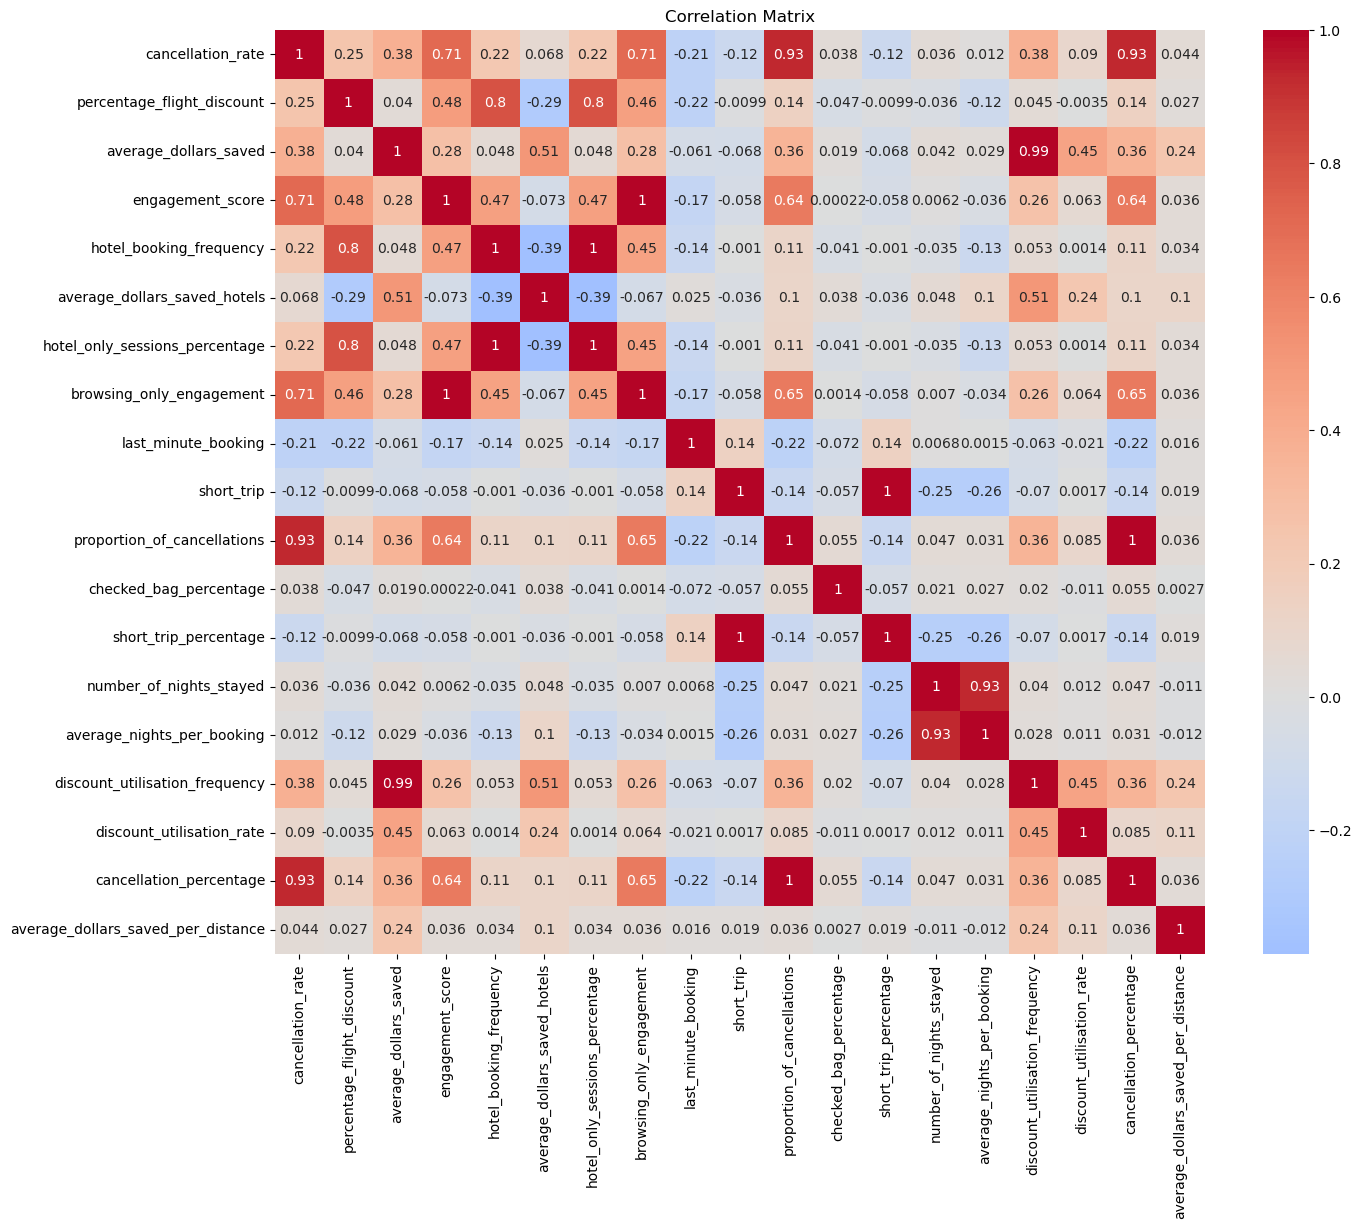

In [17]:
# Features to measure
all_features = ['cancellation_rate', 'percentage_flight_discount', 'average_dollars_saved',
                   'engagement_score', 'hotel_booking_frequency',
                   'average_dollars_saved_hotels', 'hotel_only_sessions_percentage', 'browsing_only_engagement', 'last_minute_booking', 'short_trip', 
                   'proportion_of_cancellations', 'checked_bag_percentage', 'short_trip_percentage', 'number_of_nights_stayed', 
                    'average_nights_per_booking', 'discount_utilisation_frequency', 'discount_utilisation_rate', 'cancellation_percentage', 'average_dollars_saved_per_distance']

# Calculate correlations between specified metrics
correlation_matrix = df[all_features].corr()

# Plot the correlation heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, annot_kws={'fontsize': 10})
plt.title("Correlation Matrix")
plt.show()

<b>View Correlations Between Features pt2.</b>

Based on my previous correlations I can begin to narrow down my options to features that are not too closely correlated:

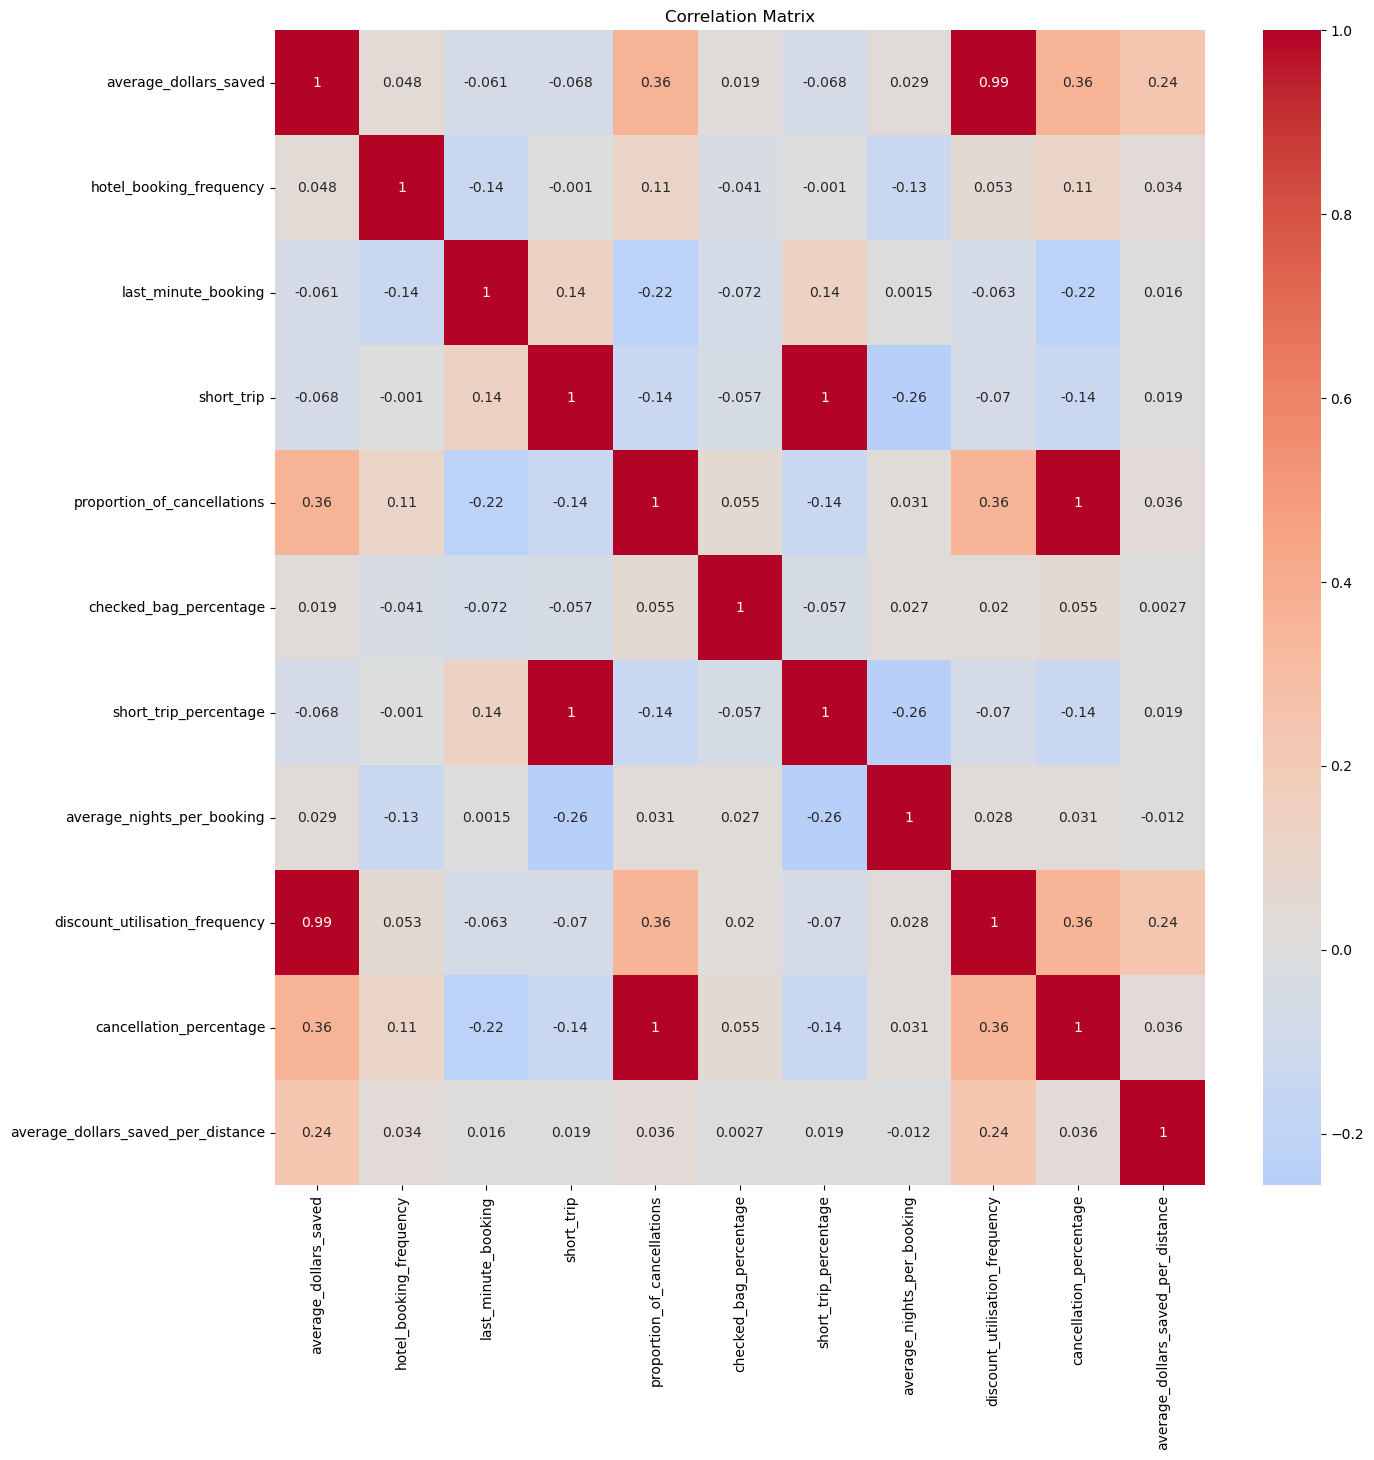

In [18]:
# Calculate correlations between specified metrics
metrics_columns = ['average_dollars_saved', 'hotel_booking_frequency',
                   'last_minute_booking', 'short_trip', 'proportion_of_cancellations', 
                   'checked_bag_percentage', 'short_trip_percentage', 'average_nights_per_booking', 
                   'discount_utilisation_frequency', 'cancellation_percentage', 'average_dollars_saved_per_distance']

correlation_matrix = df[metrics_columns].corr()

# Plot the correlation heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, annot_kws={'fontsize': 10})
plt.title("Correlation Matrix")
plt.show()

<b>Cluster Centroids with Heatmap</b>

Following a careful evaluation of the correlation heatmaps, I have selected five features for use in my K-Means clustering analysis. These features, which exhibit reasonable independence from one another, align with the respective perks as described below:

<u><b>Average_dollars_saved:</b></u> This feature calculates the average dollars saved, encompassing both flight and hotel discounts. Its relevance is particularly pronounced for the "Exclusive Discounts" perk. I believe that this value related feature performs best to extract users that would benefit from the <b>Exclusive Discounts</b> perk, but it is important to note that all value related features have a slightly higher correlation than I would like with the cancellation related features. 

<u><b>Checked_bag_percentage:</b></u> This feature quantifies the checked bag percentage by dividing the <b>total_checked_bags</b> column by the <b>total_flights_booked</b> column for each record, subsequently multiplying it by 100 to express it as a percentage. It plays a significant role in capturing behaviour relevant of the <b>Free Checked Bag</b> perk. This feature isn't too closely correlated with any other feature, and this is why I selected it to identify users that would appreciate the <b>Free Checked Bag</b> perk.

<u><b>Hotel_booking_frequency:</b></u> This feature provides insight into how frequently, on average, a user books a hotel during a single session. For example, if a user engages in 10 sessions and books hotels a total of 20 times, the <b>hotel_booking_frequency</b> would be 2, indicating that, on average, they book a hotel twice per session. Its relevance is particularly evident for the <b>Free Hotel Meal</b> perk. I wanted to use frequent hotel bookings to cluster users that may be interested in the <b>Free Hotel Meal</b> perk, and this feature wasn't too closely correlated to other features, although it does have a very slight correlation with the cancellation related features. 

<u><b>Short_trip_percentage:</b></u> This feature offers information regarding the percentage of short trips in the dataset, based on the defined threshold. It serves as a valuable metric for understanding users' tendencies to undertake short trips and holds particular relevance for the <b>One Night Free Hotel With Flight</b> perk. I felt that users who frequently booked short trips would be interested in the <b>One Night Free Hotel With Flight</b> perk, because receiving this perk on a shorter trip makes it more high value, interestingly users who take frequent short trips are not highly correlated with any of the hotel booking features, so it would also serve to entice those users into hotel related bookings. 

<u><b>Proportion_of_cancellations:</b></u> This feature calculates the ratio of cancellations to the total number of bookings, encompassing both flights and hotels, made by each user. This feature provides insights into how frequently users cancel their bookings relative to their overall booking activity. It is especially pertinent to the <b>Free Cancellation</b> perk. This particular measure has been the most difficult to manage, because there were so few cancellations overall, and because the cancellation behaviour is relatively correlated to the saving related behaviour. I believe that a <b>Free Cancellation</b> perk is going to be more beneficial to users who rarely cancel, and display lower values for the other features signifying cautious booking behaviour, because it is going to give them the security to book more trips without the worry of additional costs. While I appreciate that this might be difficult to capture due to how few cancellations there are in the dataset, I do feel that I can create a cluster that encompases this behaviour. 

Having determined the set of features suitable for my K-Means clusters, I am ready to move on to the next phase of analysis. Initially, I will create an elbow plot to visually discern the optimal number of clusters for the dataset. Subsequently, I will employ the K-Means algorithm to generate these clusters. Finally, I will inspect the cluster centroids using a heatmap. This step aims to elucidate the potential associations between clusters and perks, ultimately providing valuable insights into how different clusters relate to specific perks.

<b>Plotting the Elbow Curve</b>

The Elbow curve analysis serves as a valuable tool to determine the optimal number of clusters for a given dataset. In our case, we have a predefined requirement to work with 5 clusters, corresponding to the 5 distinct perks provided. However, this analysis is still significant because it not only validates our choice but also explores the possibility of other cluster quantities that might better suit the data. This information could prove beneficial when communicating results to the marketing team and could contribute to the final recommendation.

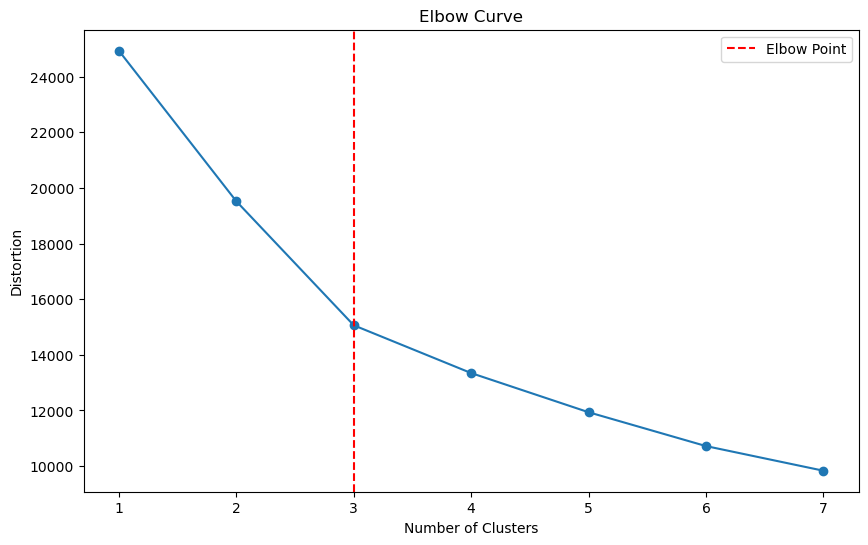

The silhouette score using 3 number of clusters is: 0.289
The silhouette score using 4 number of clusters is: 0.261
The silhouette score using 5 number of clusters is: 0.242
The silhouette score using 6 number of clusters is: 0.243


In [19]:
# Select columns for clustering
cluster_columns = ['proportion_of_cancellations', 'checked_bag_percentage', 
                   'short_trip_percentage', 'hotel_booking_frequency', 'average_dollars_saved']

# Extract the data for clustering
cluster_data = df[cluster_columns]

#Plot Elbow Curve
def plot_elbow_curve(model, data, cluster_ranges):
    distortions = []
    for num_clusters in cluster_ranges:
        model.n_clusters = num_clusters
        model.fit(data)
        distortions.append(model.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(cluster_ranges, distortions, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.title('Elbow Curve')
    
    # Add a reference line to help identify the elbow point
    plt.axvline(x=3, color='red', linestyle='--', label='Elbow Point')
    
    plt.legend()
    plt.show()


# fitting KMeans and finding appropriate amount of clusters
model = KMeans(n_clusters=5, random_state=0, n_init=10)
model.fit(cluster_data)

plot_elbow_curve(model, cluster_data, cluster_ranges=range(1, 8))
plt.show()

# Calculate silhouette scores for different numbers of clusters
for n_clusters in range(3, 7):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, tol=1e-4, random_state=0, n_init=10)
    kmeans_cluster_labels = kmeans.fit_predict(cluster_data)
    silhouette_avg = silhouette_score(cluster_data, kmeans_cluster_labels)
    print(f"The silhouette score using {n_clusters} number of clusters is: {silhouette_avg:.3f}")

The Elbow curve analysis indicates that an optimal number of clusters for the dataset would be approximately 3. However, using 5 clusters aligns with the specific task of assigning perks, and this choice is well-supported as it doesn't deviate significantly from the elbow point. While I've opted for 5 clusters due to the given perks, it's worth noting that if the elbow curve had strongly suggested another cluster quantity with a notably improved balance between within-cluster variance and the number of clusters, I might have contemplated it more closely. Such a change could even prompt a discussion with the marketing team about potentially altering the number of perks in the rewards program. This insight is likely to be included in my final recommendation.

<b>Running K-Means with the Centroids Heatmap</b>

,proportion_of_cancellations,checked_bag_percentage,short_trip_percentage,hotel_booking_frequency,average_dollars_saved
0,-0.283646,0.028258,0.979737,0.777230,-0.265295
1,-0.322589,-0.482026,-1.006439,0.096168,-0.108963
2,2.785735,0.135178,-0.406029,0.547947,1.144871
3,-0.322589,-0.275786,0.993602,-0.820133,-0.051816
4,-0.322589,1.384695,-0.814977,-0.554329,-0.068506


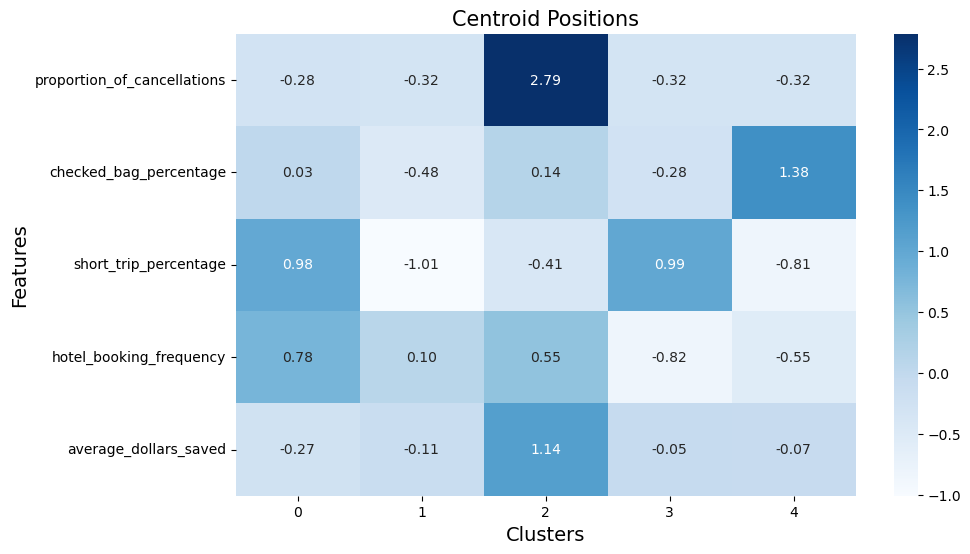

assigned_cluster
Cluster 1    1503
Cluster 0    1154
Cluster 3    1147
Cluster 4     679
Cluster 2     503
Name: count, dtype: int64


In [20]:
# Perform KMeans clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, tol=1e-4, random_state=0, n_init=10)
kmeans_cluster_labels = kmeans.fit_predict(cluster_data)

# Create a DataFrame with cluster labels
df['kmeans_cluster'] = kmeans_cluster_labels

# Display cluster centroids
model_centroids = pd.DataFrame(kmeans.cluster_centers_, columns=cluster_columns)
display(model_centroids)

# Create a heatmap to visualise cluster centroids with annotations
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(model_centroids.T, cmap="Blues", annot=True, fmt=".2f")
heatmap.set_xlabel("Clusters", fontsize=14)
heatmap.set_ylabel("Features", fontsize=14)
heatmap.set_title("Centroid Positions", fontsize=15)
plt.show()


# Analyse clusters and assign labels based on characteristics
cluster_characteristics = df.groupby('kmeans_cluster')[cluster_columns].mean()

# Determine labels based on characteristics
cluster_perk_mapping = {}

for cluster_num in range(n_clusters):
    cluster_characteristic_values = cluster_characteristics.loc[cluster_num]
    
    label = f'Cluster {cluster_num}'
    cluster_perk_mapping[cluster_num] = label

# Map clusters to assigned labels
df['assigned_cluster'] = df['kmeans_cluster'].map(cluster_perk_mapping)

# Display the count of assigned labels
perk_counts = df['assigned_cluster'].value_counts()
print(perk_counts)



<u><b>Cluster 0:</b></u>

The average <b>proportion_of_cancellations</b> is slightly negative, around -0.28, indicating a relatively low cancellation rate. This cluster has a slightly lower <b>checked_bag_percentage</b> (approximately 0.03), suggesting a lower tendency to book flights with checked bags. Customers in this cluster often take short trips, with a <b>short_trip_percentage</b> of approximately 0.98, and the <b>hotel_booking_frequency</b> is moderate, with an average value of about 0.78. The <b>average_dollars_saved</b> is negative (around -0.27), indicating limited savings.

<u><b>Cluster 1:</b></u>

This cluster has a lower <b>proportion_of_cancellations</b>, with an average value of around -0.32. Customers in this cluster have a low <b>checked_bag_percentage</b>, around -0.48, indicating no preference on bookings with checked bags. The <b>short_trip_percentage</b> is notably negative, around -1.01, suggesting a lower preference for short trips. The <b>hotel_booking_frequency</b> is moderate, with an average value of approximately 0.10, and the <b>average_dollars_saved</b> is slightly negative (around -0.11), indicating limited savings.


<u><b>Cluster 2:</b></u>

This cluster has a significantly high average <b>proportion_of_cancellations</b>, around 2.79. This suggests that customers in this cluster tend to cancel their bookings more frequently. The <b>short_trip_percentage</b> is notably negative (around -0.41) in this cluster, implying that customers here are less likely to take short trips. This cluster has a moderate <b>hotel_booking_frequency</b>, with an average value of approximately 0.55, and a lower <b>checked_bag_percentage</b> around 0.14, and customers in this cluster have a relatively high <b>average_dollars_saved</b>, around 1.14.

<u><b>Cluster 3:</b></u>

This cluster has a lower <b>proportion_of_cancellations</b>, with an average value of around -0.32. Customers in this cluster have a negative <b>checked_bag_percentage</b> (around -0.28), suggesting a low preference for booking flights with checked bags. The <b>short_trip_percentage</b> is relatively high, at around 0.99, indicating frequent short trips. This cluster exhibits a notably low <b>hotel_booking_frequency</b>, with an average value of approximately -0.82. The <b>average_dollars_saved</b> is slightly negative (around -0.05), implying limited savings.

<u><b>Cluster 4:</b></u>

The average <b>proportion_of_cancellations</b> in this cluster is around -0.32, indicating a lower cancellation rate and customers in this cluster have a notably high <b>checked_bag_percentage</b>, approximately 1.38, suggesting that they frequently book flights with checked bags. The <b>short_trip_percentage</b> is relatively low, around -0.81, indicating that customers here prefer longer trips. This cluster exhibits a lower <b>hotel_booking_frequency</b>, with an average value of about -0.55. The <b>average_dollars_saved</b> is negative (around -0.07), suggesting that customers in this cluster may not save much on their bookings.

<b>Checking the Shape and the Silhouette Score</b>

In [21]:
# Check the cluster data shape
cluster_data.shape

(4986, 5)

The shape of the clusters is exactly as we wanted, there are 5 and all rows of the dataset are included. 

In [22]:
# Compute the Silhouette Score
silhouette_avg = silhouette_score(cluster_data, df['kmeans_cluster'])

print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.24207668943997548


The Silhouette Score is a metric used to assess the quality of clustering in unsupervised machine learning tasks. It measures how similar each data point in one cluster is to the data points in the neighboring clusters. Specifically, it quantifies the separation distance between the clusters relative to the compactness of the data points within each cluster.

In this case, a Silhouette Score of 0.242 indicates the following:

This score indicates that the clusters in the dataset exhibit a moderate level of both separation and cohesion. In other words, there is some degree of distinction between the clusters, but they may not be entirely well-separated, and there could be instances of overlapping or ambiguity in cluster assignments.

It's important to note that a higher Silhouette Score closer to 1 would signify well-separated and distinct clusters, while a lower score closer to -1 would suggest clusters that are either overlapping or poorly defined. The score of 0.242 falls within the moderate range, implying a reasonable but not perfect separation of clusters.


<b>Assigning Clusters to Perks</b>

Based on the centroid positions, I have selected which cluster I believe relates to which perk:

<u><b>Cluster 0:</b></u> Cluster 0 is likely associated with the <b>Free Hotel Meal</b> perk. Members of this group have a propensity for hotel bookings, often opting for short trips. This perk proves advantageous for travelers with limited time at their destination or those seeking convenient dining solutions, who enjoy hotel related ameneties.


<u><b>Cluster 1:</b></u> Cluster 1 suggests a strong connection with the <b>Free Cancellation</b> perk. Travelers in this cluster display cost-conscious behavior and cautious booking tendencies, with a percieved reluctance to cancel, possibly relating to a cancellation fee. The offer of free cancellation allows them a sense of security, potentially encouraging them to book trips further in advance, and consider booking combination trips. I feel that the <b>Free Cancellation</b> perk is less rewarding to travellers who have already shown willingness to cancel, because it indicates that they are not put off booking by having to pay a cancellation fee. It is of my opinion that this perk is more likely to be beneficial to travellers who don't have a high number of cancellations, and who don't demonstrate high engagement within the other features, and I believe that this cluster represents this behaviour.


<u><b>Cluster 2:</b></u> Cluster 2 is closely associated with the <b>Exclusive Discounts</b> perk due to it's positive relationship with <b>average_dollars_saved.</b> It's worth noting that this cluster also comprises the majority, if not all, of the cancellations in the dataset. This can be attributed to these customers engaging more frequently in booking related behaviour, which inherently increases the likelihood of cancellations.


<u><b>Cluster 3:</b></u> Cluster 3 appears to align closely with the <b>One Night Free Hotel with Flight</b> perk. The characteristics of this group suggest a traveler who favors short trips. For individuals embarking on brief journeys, the offer of a free night in a hotel would be considered a high-vaue perk. Additionally, their infrequent booking of hotels indicates an opportunity to entice them with package deals.


<u><b>Cluster 4:</b></u> Cluster 4 is indicative of the <b>Free Checked Bag</b> perk. Travelers in this cluster generally place value on checking bags, regardless of the length of the trip, which indicates that the ability to check luggage is of high importance to these individuals.

<b>Mapping Clusters to Perk Labels</b>

Following the K-Means clustering, I proceeded to associate cluster labels with their respective perks. This involved assigning perk names to each cluster based on an analysis of their unique characteristics and centroid positions. The purpose of this mapping is to facilitate result interpretation and ensure that each cluster is correctly aligned with the corresponding perk. Consequently, I introduced a new column, <b>assigned_perk,</b> into the dataset, indicating the assigned perk for each user. This step enhances the clarity and usability of the cluster analysis results.

In [23]:
# Define a dictionary to map clusters to labels
cluster_labels_mapping = {
    0: "Free Hotel Meal",
    1: "Free Cancellation",
    2: "Exclusive Discounts",
    3: "One Night Free Hotel With Flight",
    4: "Free Checked Bag"}


# Mapping clusters to perks
df['assigned_perk'] = df['kmeans_cluster'].map(cluster_labels_mapping)


# Print labels and their corresponding clusters
labels_and_clusters = {v: k for k, v in cluster_labels_mapping.items()}
for label, cluster in labels_and_clusters.items():
    print(f"Cluster {cluster}: {label}")

Cluster 0: Free Hotel Meal
Cluster 1: Free Cancellation
Cluster 2: Exclusive Discounts
Cluster 3: One Night Free Hotel With Flight
Cluster 4: Free Checked Bag


<b>Identify and Extract Representative Samples</b>

Continuing with the analysis, the next step involves identifying and extracting representative samples from the dataset. This allows me to assess how well the assigned cluster labels align with the actual data characteristics, offering deeper insights into each cluster's unique traits.

To initiate this exploration, the code calculates the distances between individual data points and their respective cluster centroids. This distance measurement provides an indication of how closely each data point corresponds to its designated cluster's central characteristics. While I can't visualise all data points for every cluster here due to the data's size, I do take a look at a subset to gauge their proximity to the cluster centroids. This preliminary analysis serves as a quick check to validate the accuracy of the clustering results.

I proceed to select a subset of data points, often referred to as <b>representative samples.</b> These samples are chosen based on a predetermined percentage of data points within each cluster. This approach ensures that the selected samples offer a comprehensive view of the typical traits and behaviors associated with each customer segment. 

In [24]:
# Calculate distances to cluster centroids and add as columns to the DataFrame
cluster_distances = kmeans.transform(cluster_data)
for i in range(n_clusters):
    df[f'distance_to_centroid_{i}'] = cluster_distances[:, i]

# Define the percentage of data points to select as representative samples
percentage_to_select = 0.25

# Create a DataFrame to store representative samples
representative_samples = pd.DataFrame()

# Iterate through clusters
for cluster_num in range(n_clusters):
    # Sort data points within the cluster by distance to centroid
    cluster_column = f'kmeans_cluster_{cluster_num}'
    sorted_df = df[df['kmeans_cluster'] == cluster_num].sort_values(by=f'distance_to_centroid_{cluster_num}')

    # Calculate the number of data points to select as representative samples
    num_samples = int(len(sorted_df) * percentage_to_select)

    # Select the top N data points with the smallest distances as representative samples
    selected_samples = sorted_df.head(num_samples)

    # Append the selected samples to the representative_samples DataFrame
    representative_samples = pd.concat([representative_samples, selected_samples])

# Define the relevant columns
columns_for_clustering = ['user_id', 'assigned_cluster'] + ['average_dollars_saved', 'checked_bag_percentage',
                   'hotel_booking_frequency', 'short_trip_percentage', 'proportion_of_cancellations']
distance_columns = [f'distance_to_centroid_{i}' for i in range(n_clusters)]

# Select only the relevant columns and the top 5 rows
relevant_samples = representative_samples[columns_for_clustering + distance_columns].head(5)

# Display the relevant columns in a table
display(relevant_samples.style.hide(axis='index'))


user_id,assigned_cluster,average_dollars_saved,checked_bag_percentage,hotel_booking_frequency,short_trip_percentage,proportion_of_cancellations,distance_to_centroid_0,distance_to_centroid_1,distance_to_centroid_2,distance_to_centroid_3,distance_to_centroid_4
524012,Cluster 0,-0.408301,0.197052,0.936659,0.993602,-0.322589,0.275805,2.292889,3.766685,1.853908,2.649520
591097,Cluster 0,-0.408301,0.197052,0.936659,0.993602,-0.322589,0.275805,2.292889,3.766685,1.853908,2.649520
546072,Cluster 0,-0.408301,0.197052,0.936659,0.993602,-0.322589,0.275805,2.292889,3.766685,1.853908,2.649520
511860,Cluster 0,-0.408301,0.197052,0.936659,0.993602,-0.322589,0.275805,2.292889,3.766685,1.853908,2.649520
526471,Cluster 0,-0.408301,0.197052,0.936659,0.993602,-0.322589,0.275805,2.292889,3.766685,1.853908,2.649520


The output provides a snapshot of the characteristics of representative samples within <b>Cluster 0,</b> denoted as <b>Free Hotel Meal.</b> Here's what the data reveals about this cluster:

<u><b>User Behavior Consistency:</b></u> Cluster 0's users achieve an average savings score of approximately -0.4083. In this context, a negative score suggests that these users do not typically experience savings when making bookings, indicating that they place less important on monetary savings.

<u><b>Travel Preferences:</b></u> Members of this cluster show a moderate inclination towards checked bags, with a checked bag percentage of 19.71%. This suggests that while some members could appreciate checked bags, it's not their primary focus when booking flights. Users in this representative sample generally have similar frequencies of hotel bookings.

<u><b>Proportion of Cancellations:</b></u> In Cluster 0, users exhibit a notably low proportion of cancellations, with values consistently around -0.3226. This suggests that within this cluster, travelers rarely cancel their bookings.

<u><b>Proximity to Cluster Centroid:</b></u> The <b>distance_to_centroid</b> values demonstrate that the representative samples within Cluster 0 are closely positioned to the cluster's centroid, indicating a high degree of uniformity within this segment. In the representative sample, most users have a cluster-to-centroid value of approximately 0.276.

In summary, <b>Cluster 0,</b> representing the <b>Free Hotel Meal</b> perk, comprises individuals who consistently exhibit specific behavioral patterns. They prioritize short trips, as indicated by their notably high <b>short_trip_percentage</b> of approximately 99.36%. While they do exhibit a moderate inclination towards checked bags (19.71%), it's not their primary focus when booking flights. Hotel bookings are moderate and consistent. Notably, they rarely cancel their bookings, with a <b>proportion_of_cancellations</b> around -0.3226. The cluster demonstrates a high degree of uniformity, with most users closely positioned to the cluster's centroid (around 0.276), indicating a cohesive segment

<b>Pivoting the DataFrame to Create a Summary Table</b>

To better grasp the relationships between our identified clusters and their associated perks, I've simplified the data presentation. I've pivoted the DataFrame to align cluster labels on the left with cluster-specific columns at the top. This arrangement offers a clear view of how each cluster behaves across various features.

By calculating mean values within this structured format, we can easily visualise and compare each cluster's characteristics concerning their assigned perks. This approach simplifies the understanding of cluster traits and strengthens our analysis narrative.

In [25]:
# Pivot the DataFrame
pivoted_data = df.pivot_table(index='assigned_perk', values=cluster_columns, aggfunc='mean')


# Display the pivoted data
display(pivoted_data)
pivoted_data = df.pivot_table(index='assigned_perk', values=cluster_columns)



,average_dollars_saved,checked_bag_percentage,hotel_booking_frequency,proportion_of_cancellations,short_trip_percentage
assigned_perk,,,,,
Exclusive Discounts,1.144871,0.135178,0.547947,2.785735,-0.406029
Free Cancellation,-0.108963,-0.482026,0.096168,-0.322589,-1.006439
Free Checked Bag,-0.068506,1.384695,-0.554329,-0.322589,-0.814977
Free Hotel Meal,-0.265295,0.028258,0.777230,-0.283646,0.979737
One Night Free Hotel With Flight,-0.051816,-0.275786,-0.820133,-0.322589,0.993602


The output provides insights into the clusters and their assigned perks:

<u><b>Exclusive Discounts:</b></u> Customers in the <b>Exclusive Discounts</b> cluster exhibit notably higher values in <b>average_dollars_saved,</b> suggesting a strong inclination toward saving money. Some users in this cluster may demonstrate a preference for checked bags, as indicated by the <b>checked_bag_percentage</b> value. They have a moderate <b>hotel_booking_frequency,</b> and their high <b>proportion_of_cancellations</b> suggests a relatively higher cancellation rate. Interestingly, members of this cluster don't prioritise short trips, as evident from the <b>short_trip_percentage.</b> The <b>Exclusive Discounts</b> perk would be highly attractive to these types of users, and may even lead to less cancellations over time.

<u><b>Free Cancellation:</b></u> In contrast, the <b>Free Cancellation</b> cluster showcases lower <b>average_dollars_saved</b> and <b>checked_bag_percentage</b> values, indicating a lesser importance on cost savings and checked bags. Members of this cluster tend to book hotels at a low frequency and are less likely to cancel their bookings. Additionally, they exhibit a strong preference for longer trips over short ones, as indicated by the negative <b>short_trip_percentage.</b> Members of this group display more cautious booking tendencies, and it is likely that the free cancellation perk would give them more security, and encourage a higher level of engagement with the service. 

<u><b>Free Checked Bag:</b></u> Customers assigned to the <b>Free Checked Bag</b> cluster exhibit a particular interest in checked bags, with a significantly high <b>checked_bag_percentage.</b> This group also displays a lower <b>hotel_booking_frequency,</b> and their <b>proportion_of_cancellations</b> values are notably low, indicating a lower likelihood of cancellations. Members of this cluster tend to prefer taking longer trips, as evidenced by their negative <b>short_trip_percentage.</b> Users who already prioritise checking bags are going to appreciate the <b>Free Checked Bag</b> perk, because regardless of trip length they are likely willing to factor that expense into their booking, because it is something that is important to them. Offering them the <b>Free Checked Bag</b> perk is going to align with their preferences, but it could also encourage them to spend the money they would have spent on checking their luggage on another aspect of their trip. 

<u><b>Free Hotel Meal:</b></u> This cluster exhibits a relatively high <b>hotel_booking_frequency,</b> while their <b>average_dollars_saved</b> and <b>checked_bag_percentage</b> are relatively low. The <b>proportion_of_cancellations</b> in this cluster indicates a relatively low cancellation rate. Their <b>short_trip_percentage</b> is quite high suggesting a preference for shorter trips within this cluster. Their preference for hotel related bookings and shorter trips makes them a good candidate for the <b>Free Hotel Meal</b> perk, because it indicates that they enjoy hotel stays and the ameneties they offer.

<u><b>One Night Free Hotel With Flight:</b></u> This cluster exhibits lower <b>average_dollars_saved</b> and <b>checked_bag_percentage</b> values, indicating a lesser emphasis on cost savings and checked bag perks. Their <b>hotel_booking_frequency</b> is relatively low, suggesting infrequent hotel bookings. Additionally, this cluster demonstrates a low cancellation rate. Contrary to some other clusters, their <b>short_trip_percentage</b> suggests a preference for shorter trips rather than longer ones. Users in this cluster could benefit more from a free night in a hotel with their flight, as they tend to take shorter trips which would make this perk high value. Additionally it may entice them to start making more combination bookings.

In summary, the cluster labels seem to correspond to the distinctive traits and preferences of each customer segment, as evidenced by their feature values. However, it's essential to bear in mind that these insights are drawn from the provided data and feature metrics, and further analysis or validation may be necessary to affirm the accuracy of these labels.

<b>Assessing Cluster Cohesion</b>

Continuing the analysis, I have shifted the focus to assess the cohesion and quality of the assigned clusters. This step aims to gauge the internal consistency of the clusters, each representing a distinct perk category. By calculating the mean Euclidean distance between data points within each cluster and their respective centroid, we gain valuable insights into the cohesion and similarity of data within each cluster. This information sheds light on how closely related and homogeneous the data points are within their respective clusters.

In [26]:
# Initialise a list to store dictionaries
distances_list = []

# Iterate through cluster labels
for cluster_label in cluster_labels_mapping.values():
    # Filter data points for the current cluster
    cluster_data = df[df['assigned_perk'] == cluster_label]
    
    # Select only the numeric columns for distance calculations
    numeric_cluster_data = cluster_data[cluster_columns].select_dtypes(include=[np.number])
    
    # Check if there are any rows left in the DataFrame
    if not numeric_cluster_data.empty:
        # Calculate the Euclidean distances between data points and the centroid of the current cluster
        distances = euclidean_distances(numeric_cluster_data, [numeric_cluster_data.mean()])
        
        # Append a dictionary to the list
        distances_list.append({'cluster_label': cluster_label, 'dist_center': distances.mean()})

# Create a DataFrame from the list of dictionaries
distances_df = pd.DataFrame(distances_list)

# Display the distances DataFrame
display(distances_df)

,cluster_label,dist_center
0,Free Hotel Meal,1.243703
1,Free Cancellation,1.381207
2,Exclusive Discounts,2.059403
3,One Night Free Hotel With Flight,1.297112
4,Free Checked Bag,1.469919


The dist_center values in the output represent the mean Euclidean distances between data points within each cluster and the centroid of that cluster.

<u><b>Free Hotel Meal:</b></u> This cluster exhibits the lowest mean distance of 1.243703 to its centroid. This value indicates that data points within this cluster are relatively similar to each other concerning the features considered for clustering analysis

<u><b>Free Cancellation:</b></u> This cluster also displays a relatively low mean distance to its centroid (1.381207). This proximity signifies that data points within this cluster share common characteristics, exhibiting limited variability and a higher degree of coherence.

<u><b>Exclusive Discounts:</b></u> This cluster is also marked by a relatively low mean distance to its centroid, although it is the highest of the group (2.059403). Although the mean is slightly higher, this proximity does still indicate that data points within this cluster share common traits, displaying a higher degree of similarity and coherence.

<u><b>One Night Free Hotel With Flight:</b></u> This cluster demonstrates a mean distance to it's centroid of 1.297112. This proximity highlights a degree of homogeneity within the cluster, indicating that data points within this cluster share common traits and exhibit a high level of similarity and coherence.

<u><b>Free Checked Bag:</b></u> This cluster has a low mean distance of 1.469919 to its centroid. This suggests that data points within this cluster are close to the centroid, signifying a higher level of homogeneity and similarity.


In summary, the clusters consistently display relatively low mean distances to their centroids, signifying that the data points within each cluster share common characteristics and are closely aligned in terms of the features considered for clustering analysis.

<b>Distribution of Clusters vs Features</b>

In this code section, I explore how different features are distributed across the defined clusters using Kernel Density Estimates (KDE). Each subplot in the resulting figure represents a specific feature, and within each subplot, I can visualise how each cluster's data is distributed within that feature. This approach gives me a visual sense of how these features vary among the clusters, helping me to identify any noteworthy patterns or differences.

I've opted to focus on plotting the distributions for the features <b>average_dollars_saved, checked_bag_percentage, and hotel_booking_frequency.</b> This decision was made because the <b>proportion_of_cancellations</b> and <b>short_trip_percentage</b> features exhibit limited variability, making them less suitable for KDE plots. By excluding these features, I can ensure a clearer and more insightful analysis while avoiding potential issues related to singular metrics.

In [27]:
# Data
data = df  

# Columns of interest
short_trip_column = "short_trip_percentage"
cancellation_column = "proportion_of_cancellations"

# Describe the distribution of values
short_trip_description = data[short_trip_column].describe()
cancellation_description = data[cancellation_column].describe()

# Print the descriptions
print(f"Description of {short_trip_column}:\n{short_trip_description}\n")
print(f"Description of {cancellation_column}:\n{cancellation_description}")


Description of short_trip_percentage:
count    4.986000e+03
mean    -1.353822e-17
std      1.000100e+00
min     -1.006439e+00
25%     -1.006439e+00
50%      9.936025e-01
75%      9.936025e-01
max      9.936025e-01
Name: short_trip_percentage, dtype: float64

Description of proportion_of_cancellations:
count    4.986000e+03
mean    -3.633943e-17
std      1.000100e+00
min     -3.225887e-01
25%     -3.225887e-01
50%     -3.225887e-01
75%     -3.225887e-01
max      9.702335e+00
Name: proportion_of_cancellations, dtype: float64


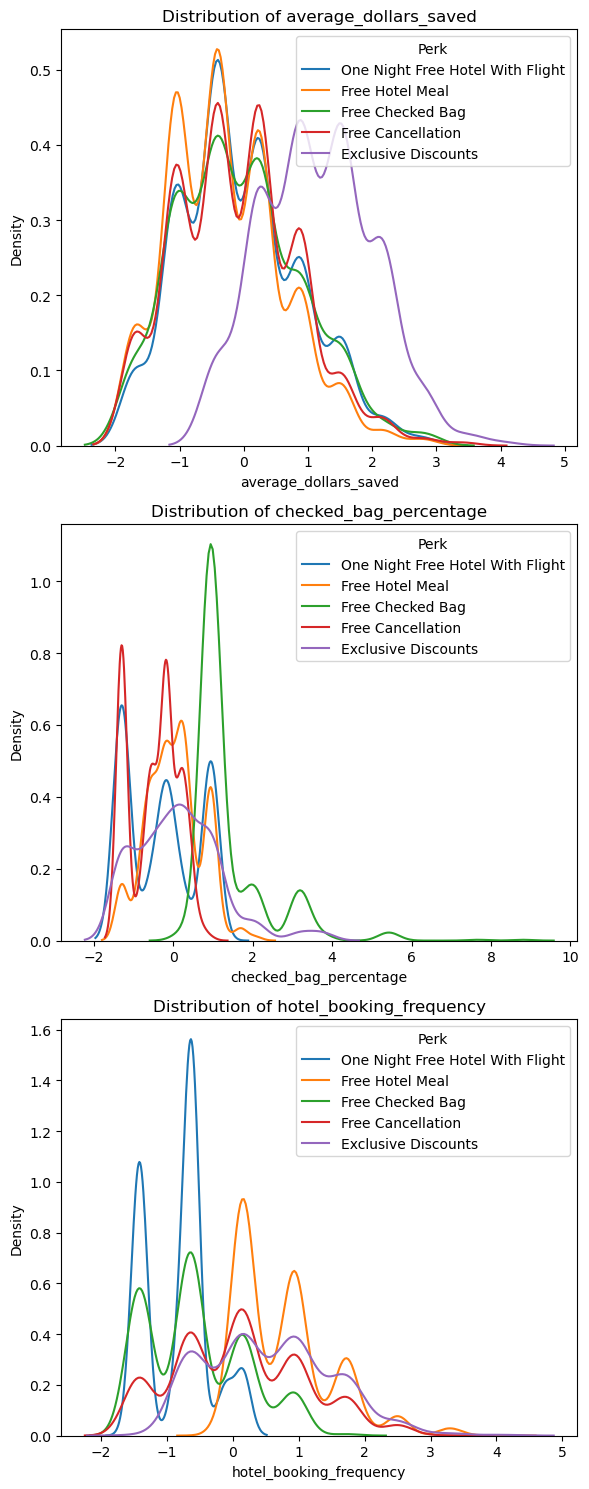

In [28]:
# Define the list of features
list_of_features = ["average_dollars_saved", "checked_bag_percentage", "hotel_booking_frequency"]

# Create subplots for each feature
fig, axes = plt.subplots(nrows=len(list_of_features), ncols=1, figsize=(6, 15))

# Loop through each feature and plot KDE for each perk
for i, feature in enumerate(list_of_features):
    ax = axes[i]
    for perk in df['assigned_perk'].unique():
        sns.kdeplot(data=df[df['assigned_perk'] == perk], x=feature, label=perk, ax=ax)
    ax.set_title(f"Distribution of {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Density")
    ax.legend(title="Perk")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()






<span style="font-size:16px; color:#007acc">Key Observations:</span>

The KDE plots offer valuable insights into the data distribution among clusters. One notable observation is that while there are some distinct behavioral patterns, there's also a considerable degree of overlap among the clusters. This overlap implies a degree of similarity between them, which warrants further exploration.

For instance, I observe a broader distribution in the <b>"Free Hotel Meal"</b> perk for the <b>hotel_booking_frequency feature</b>, aligning with my expectations. Similarly, the <b>"Free Checked Bag"</b> and <b>"Exclusive Discounts"</b> perks exhibit wider distributions in the <b>checked_bag_percentage</b> and <b>average_dollars_saved</b> features, respectively. However, the presence of overlap between clusters suggests that there may be shared characteristics or behaviors worth investigating in greater detail.


<b>Using Box Plots to Assess the Overlap Between Features</b>

Next, in response to the observed overlap in the KDE plots, I am utilising box plots to further explore and visualise the extent of this overlap between the different clusters. Box plots provide a concise representation of the data's distribution, highlighting any commonalities or variations within and between clusters. 

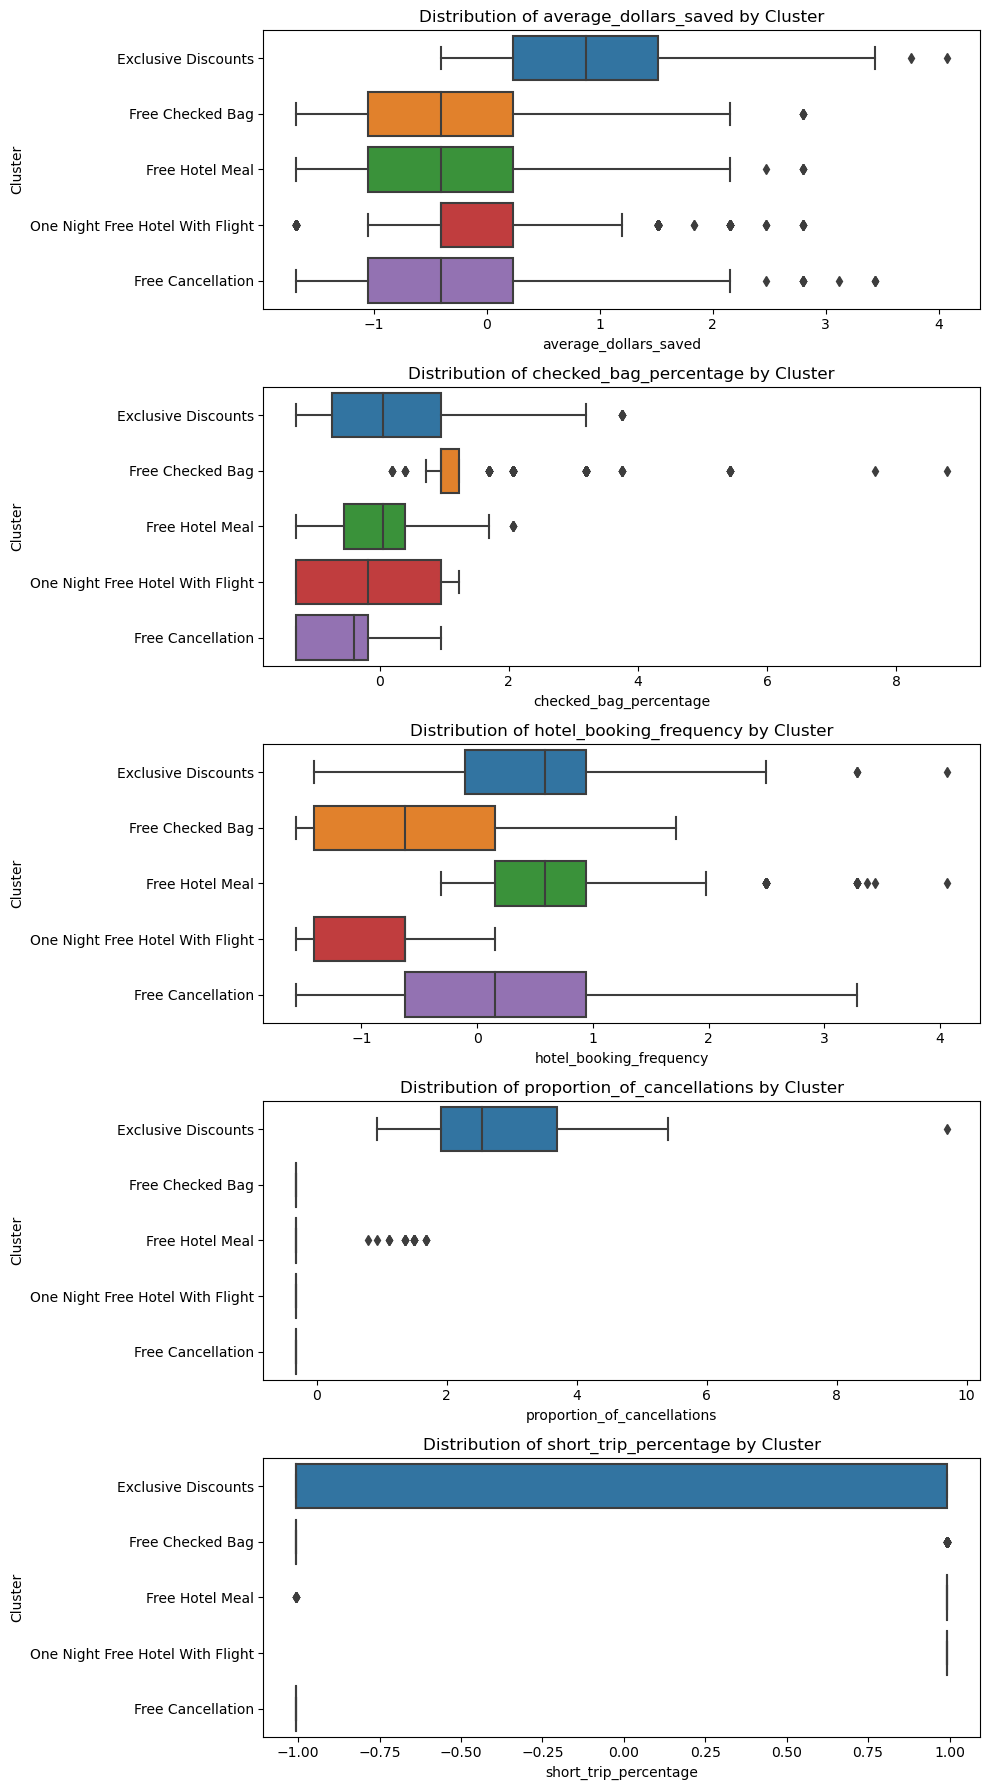

In [29]:
# Define the list of cluster labels
labels_of_clusters = ["Exclusive Discounts", "Free Checked Bag", "Free Hotel Meal", "One Night Free Hotel With Flight", "Free Cancellation"]

# Define the list of features
features_to_check = ["average_dollars_saved", "checked_bag_percentage", "hotel_booking_frequency", "proportion_of_cancellations", "short_trip_percentage"]

# Create subplots for each feature
fig, axes = plt.subplots(nrows=len(features_to_check), ncols=1, figsize=(10, 18)) 

# Loop through each feature and create box plots for each cluster
for i, feature in enumerate(features_to_check):
    ax = axes[i]
    sns.boxplot(data=df, x=feature, y="assigned_perk", order=labels_of_clusters, ax=ax) 
    ax.set_title(f"Distribution of {feature} by Cluster")
    ax.set_xlabel(feature)
    ax.set_ylabel("Cluster")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()






The box plots reveal distinct patterns of overlap and separation among the clusters, providing valuable insights into customer preferences and behaviors:

<u><b>Distinct Clusters:</b></u>

<u><b>Exclusive Discounts:</b></u> Within this cluster, customers clearly prioritize cost-effective bookings, as indicated by the unique distribution of average dollars saved.

<u><b>Free Hotel Meal:</b></u> The <b>Free Hotel Meal</b> cluster displays unique characteristics, especially in <b>hotel_booking_frequency,</b> with both higher starting and ending values compared to other clusters. However, there is some minor overlap with the <b>Exclusive Discounts</b> cluster.

<u><b>Key Takeaways:</b></u>

<u><b>Free Checked Bag:</b></u> Although smaller in size and not entirely distinct, this cluster stands out due to its higher starting value in <b>checked_bag_percentage</b> and the heightened presence of outliers. These findings suggest that users in this cluster do have a preference for the <b>Free Checked Bag</b> perk, although the cluster is not prefect.

<u><b>Additional Insights:</b></u>

It's worth noting that for the <b>proportion_of_cancellations</b> and <b>short_trip_percentage</b> features, there is minimal variability or spread among the clusters. This observation aligns with the fact that most users had zero cancellations, and the data in the short trip percentage column exhibited limited variability.

Considering these insights, it may be beneficial to explore the possibility of consolidating clusters or implementing a multi-level rewards program with varying perks to cater to different stages of customer engagement. This approach could enhance customer satisfaction and loyalty by aligning rewards with evolving preferences and behaviors, a strategy also supported by the Elbow plot and Silhouette score analyses, which indicated an optimal cluster count of three.

<b>Conclusions</b>

- <b>Exclusive Discounts:</b> Within this cluster, customers clearly prioritize cost-effective bookings, as indicated by the unique distribution of <b>average_dollars_saved.</b>

- <b>Free Hotel Meal:</b> The <b>Free Hotel Meal</b> cluster displays unique characteristics, especially in <b>hotel_booking_frequency,</b> with both higher starting and ending values compared to other clusters. However, there is some minor overlap with the <b>Exclusive Discounts</b> cluster.

- <b>Free Checked Bag:</b> Although smaller in size and not entirely distinct, this cluster stands out due to its higher starting value in <b>checked_bag_percentage</b> and the heightened presence of outliers. These findings suggest that users in this cluster do have a preference for the <b>Free Checked Bag</b> perk, although the cluster is not perfect.

- For the <b>proportion_of_cancellations</b> and <b>short_trip_percentage</b> features, there is minimal variability or spread among the clusters. This observation aligns with the fact that most users had zero cancellations, and the data in the short trip percentage column exhibited limited variability.

<b>Recomendations</b>

- <u><b>Multi-Level Rewards Program:</b></u> Consider implementing a multi-level rewards program with varying perks to cater to different stages of customer engagement. This approach could enhance customer satisfaction and loyalty by aligning rewards with evolving preferences and behaviors. As supported by the clustering analysis, customers do demonstrate an overlap in preference for some of the perks so this could resonate with their preferences and encourage an increase in booking related behaviour.

- <u><b>Consolidation of Overlapping Perks:</b></u> Evaluate the possibility of consolidating perks that exhibit significant overlap among clusters. For instance, the <b>Exclusive Discounts</b> and <b>Free Hotel Meal</b> clusters overlap, suggesting shared preferences. Combining these perks into a single, comprehensive offering could simplify the rewards program and reduce redundancy, aligning it with the optimal cluster count of 3, as indicated by the Elbow Plot and Silhouette Score analysis. This step enhances the rewards program's coherence and makes it easier to tailor perks to customer preferences.

- <u><b>Larger Dataset for Improved Variability:</b></u> Reiterate the clustering process using a larger dataset obtained over an extended period of time. This expanded dataset may introduce more variability, especially in the cancellation-related data, enabling a more nuanced segmentation of customer preferences. A broader and more representative dataset can refine the rewards program's targeting strategies.

- <u><b>Feedback Mechanism:</b></u> Implement a feedback mechanism within the rewards program to gather insights directly from customers. Encourage participants to provide feedback on the perks they value most, as well as suggestions for new offerings. This proactive approach can help fine-tune the rewards program based on real-time input from customers, ensuring that it remains relevant and appealing to their evolving preferences.

- <u><b>Targeted Marketing Strategies:</b></u> Utilise the cluster insights to develop highly targeted marketing campaigns. Craft promotions and advertisements that specifically cater to the preferences and behaviors of each cluster. Tailoring marketing messages and perks to align with the identified clusters can significantly enhance engagement and conversion rates, resulting in improved customer satisfaction and loyalty.



<b>Saving the Amended DataFrame</b>

Finally, I am saving my amended dataframe as a CSV file so that I can use it to create a tableau dashboard where I can derive further insights that can be viewed by the marketing team.

In [30]:
# Save the amended DataFrame as a new CSV file
output_csv_filename = 'TravelTide_for_Tableau.csv'
df.to_csv(output_csv_filename, index=False)

print(df.head())

   user_id  birthdate gender  married  has_children home_country    home_city  \
0    94883 1972-03-16      F        1             0          usa  kansas city   
1   153982 1978-08-15      F        0             1       canada      toronto   
3   181157 1970-08-10      F        1             0          usa      houston   
4   252835 1986-01-20      F        0             1          usa      chicago   
5   283325 1973-05-15      F        1             0          usa       dallas   

  home_airport sign_up_date  num_sessions  ...  \
0          MCI   2022-02-07     -0.448268  ...   
1          YKZ   2022-04-19     -0.448268  ...   
3          HOU   2022-05-15     -0.448268  ...   
4          ORD   2022-07-18     -0.448268  ...   
5          DAL   2022-08-12     -0.448268  ...   

   discount_utilisation_frequency  average_dollars_saved_per_distance  \
0                       -1.034848                           -0.301787   
1                       -1.034848                           -0.239